## Step 0: Imports and Initialization

In [0]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

import tensorflow_datasets as tfds
import tensorflow as tf

We'll use the IMDB dataset built into TF. We can load it using the the TFDS module.

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCQXQ9O/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCQXQ9O/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCQXQ9O/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Loading this dataset gives us two objects. `dataset` is a dictionary of Dataset objects split into training and test sets. `info` gives us a DatasetInfo object with many important properties of `dataset`, most notably **the encoder**.

In [0]:
train_dataset, test_dataset = dataset['train'], dataset['test']
encoder = info.features['text'].encoder

The encoder is responsible for turning our text data into vectors. It isn't too important exactly what the encoder does here, but make sure anything it does is fully **reversible**.

Take a look at the encoder in action below.

In [4]:
encoder.encode('Hello world!')

[4025, 222, 562, 7962]

In [5]:
encoder.decode([4025, 222, 562, 7962])

'Hello world!'

To finish formatting our data, we still need to shuffle and pad it. 

Shuffling the data ensures our data is in a random order, while padding forces all input/output data into the same length. Here, `BUFFER_SIZE` dictates the size of any given sample of the datasets. `BATCH_SIZE` determines the size of the longest vector in our dataset (in this case 64).

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Step 1: Building the model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


As with our CNN in the `classify_digits` example, our model uses keras's `Sequential` API. Let's look at each of our layers:
1. Embedding: This layer transforms an encoded vector using the encoder above into a one-hot encoded vector with the encoder's dictionary. This process is also trainable, which means that vectors created here will be 'grouped' with other vectors with similar meanings. It isn't too important to understand exactly *how* it works, but it is quite similar to other word vectorization functions like `word2vec` and results in better efficiency.
2. Bidirectional: [A bidirectional RNN layer](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) with LSTM features built-in. 
3. Dense (output) layers: The result of the RNN passes through one layer, where it is transformed from our length 64 vector into a word (essentially "undoing" the embedding). Then the final dense layer condenses it into a single output.

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


Again, we have to compile our model before training it. We use the same parameters as `classify_digits` with one major distinction: the loss function. 

Since we are classifying between two choices, it's preferred to use binary cross-entropy loss rather than categorical. 

## Step 2: Training the model

In [9]:
hist = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 831s 2s/step - loss: 0.5585 - accuracy: 0.6814 - val_loss: 0.6055 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 858s 2s/step - loss: 0.4781 - accuracy: 0.7693 - val_loss: 0.4360 - val_accuracy: 0.8026
Epoch 3/10
391/391 [==============================] - 860s 2s/step - loss: 0.3304 - accuracy: 0.8630 - val_loss: 0.3973 - val_accuracy: 0.8281
Epoch 4/10
391/391 [==============================] - 855s 2s/step - loss: 0.3086 - accuracy: 0.8769 - val_loss: 0.4886 - val_accuracy: 0.7437
Epoch 5/10
391/391 [==============================] - 857s 2s/step - loss: 0.3583 - accuracy: 0.8342 - val_loss: 0.3938 - val_accuracy: 0.8359
Epoch 6/10
391/391 [==============================] - 859s 2s/step - loss: 0.2154 - accuracy: 0.9161 - val_loss: 0.4543 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 863s 2s/step - loss: 0.1772 - accuracy: 0.9342 - val_loss: 0.4433 - val_accuracy: 0.8313

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


391/391 [==============================] - 188s 481ms/step - loss: 0.5524 - accuracy: 0.7884
Test Loss: 0.5524201989173889
Test Accuracy: 0.7883999943733215


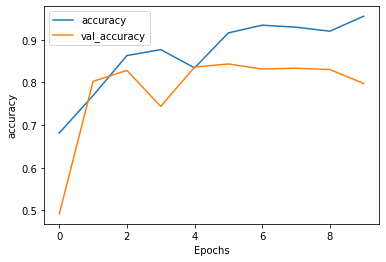

In [11]:
plot_graphs(hist, 'accuracy')

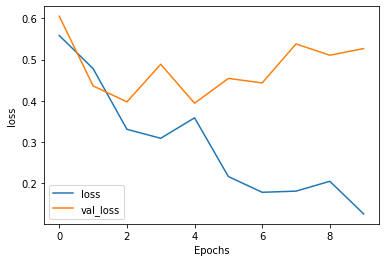

In [12]:
plot_graphs(hist, 'loss')

Expectedly, accuracy increases and loss decreases as training continues. Even so, we see test accuracy starting to plateau and eventually decreasing. This could be a sign of overfitting, which we can deal with later.

We can continue to add more LSTM RNN layers easily using Keras APIs. 

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

We just have to stack layers together. To slightly alleviate our overfitting problem, we add a dropout layer before our final dense output layer as well. 

Note that our single RNN layer in the last example already takes a long time to train. Adding more layers takes even longer, which is why we didn't run the cell above. 

## Footnotes
* The encoder we use here is trained to hash word pieces rather than each character, but falls back on character level encoding when it doesn't recognize a part of the word. This saves memory when building vectors. For more information about the specific encoder used here, check out the documentation on TF's [subword level encoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).
* For a more detailed look at the Embedding layer, head over to [this StackOverflow post](https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work).